#### Importar las librerías y los datasets sobre los que trabajar

In [2]:
!pip install tensorflow

     ------------------------------------- 266.3/266.3 MB 19.8 MB/s eta 0:00:00
     -------------------------------------- 124.6/124.6 kB 7.1 MB/s eta 0:00:00
     ---------------------------------------- 439.2/439.2 kB ? eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB ? eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 84.6 MB/s eta 0:00:00
     ---------------------------------------- 6.0/6.0 MB 76.7 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB ? eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 79.4 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 104.7 MB/s eta 0:00:00
     --------------------------------------- 14.2/14.2 MB 65.5 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 92.3 MB/s eta 0:00:00
     ------------------------------------- 895.9/895.9 kB 55.4 MB/s eta 0:00:00
     ---------------------------------------- 177.0/177.0 kB ? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import tweepy
from tweepy import OAuthHandler
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut
from sklearn import neural_network
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from sklearn.metrics import accuracy_score
from keras.layers import Input

ModuleNotFoundError: No module named 'tensorflow'

#### Datasets elegidos

In [2]:
df_precio = pd.read_csv("BTC-USD.csv")

In [ ]:
df_tweets = pd.read_csv("Bitcoin_tweets.csv")
df_tweets

#### Limpiar datos y aportar nuevos al dataset de precio

In [12]:
df_precio = df_precio.drop(['High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
df_precio = df_precio.rename(columns={"Date": "Fecha", "Open": "Precio"})

precio_1d_atras = list()
precio_7d_atras  = list()
precio_1d_despues = list()
precio_7d_despues = list()

for i in range(len(df_precio)):
    if(i>0):   
        precio_1d_atras.append(df_precio.iloc[i-1,1])
    else:
        precio_1d_atras.append(df_precio.iloc[i,1]) # Si no hay suficientes dias antes, asignarle el precio del dia actual, para que no se quede vacio y de problemas
      
    if(i>6):
        precio_7d_atras.append(df_precio.iloc[i-7,1])
    else:
        precio_7d_atras.append(df_precio.iloc[i,1]) # Si no hay suficientes dias antes, asignarle el precio del dia actual, para que no se quede vacio y de problemas
        
    if(i<len(df_precio)-1):
        precio_1d_despues.append(df_precio.iloc[i+1,1])
    else:
        precio_1d_despues.append(df_precio.iloc[i,1]) # Si no hay suficientes dias antes, asignarle el precio del dia actual, para que no se quede vacio y de problemas
        
    if(i<len(df_precio)-7):
        precio_7d_despues.append(df_precio.iloc[i+7,1])
    else:
        precio_7d_despues.append(df_precio.iloc[i,1]) # Si no hay suficientes dias antes, asignarle el precio del dia actual, para que no se quede vacio y de problemas
    
df_precio.loc[:, '1d_atras'] = precio_1d_atras
df_precio.loc[:, '7d_atras'] = precio_7d_atras
df_precio.loc[:, '1d_despues'] = precio_1d_despues
df_precio.loc[:, '7d_despues'] = precio_7d_despues
df_precio

,Fecha,Precio,1d_atras,7d_atras,1d_despues,7d_despues
0,2014-09-17,465.864014,465.864014,465.864014,456.859985,435.751007
1,2014-09-18,456.859985,465.864014,456.859985,424.102997,423.156006
2,2014-09-19,424.102997,456.859985,424.102997,394.673004,411.428986
3,2014-09-20,394.673004,424.102997,394.673004,408.084991,403.556000
4,2014-09-21,408.084991,394.673004,408.084991,399.100006,399.471008
...,...,...,...,...,...,...
2571,2021-10-01,43816.742188,41551.269531,44894.300781,48137.468750,43816.742188
2572,2021-10-02,48137.468750,43816.742188,42840.890625,47680.027344,48137.468750
2573,2021-10-03,47680.027344,48137.468750,42721.628906,48208.906250,47680.027344
2574,2021-10-04,48208.906250,47680.027344,43234.183594,49164.750000,48208.906250


#### Mostrar grafica con los primeros [rango1] dias del nuevo dataset de precios

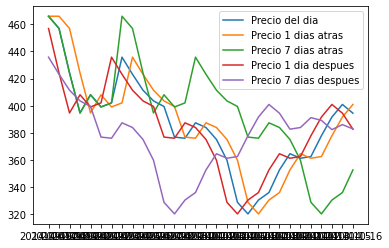

In [26]:
rango1 = 30
pl.plot(df_precio.iloc[0:rango1,0], df_precio.iloc[0:rango1,1], label = "Precio del dia")
pl.plot(df_precio.iloc[0:rango1,0], df_precio.iloc[0:rango1,2], label = "Precio 1 dias atras")
pl.plot(df_precio.iloc[0:rango1,0], df_precio.iloc[0:rango1,3], label = "Precio 7 dias atras")
pl.plot(df_precio.iloc[0:rango1,0], df_precio.iloc[0:rango1,4], label = "Precio 1 dia despues")
pl.plot(df_precio.iloc[0:rango1,0], df_precio.iloc[0:rango1,5], label = "Precio 7 dias despues")
pl.legend()
pl.show()

#### Cambiar precios anteriores y posteriores a porcentajes (mayor interpretabilidad)

In [ ]:
df_precio['1d_atras'] = df_precio['1d_atras'] / df_precio['Precio'] * 100
df_precio['7d_atras'] = df_precio['7d_atras'] / df_precio['Precio'] * 100
df_precio['1d_despues'] = df_precio['1d_despues'] / df_precio['Precio'] * 100
df_precio['7d_despues'] = df_precio['7d_despues'] / df_precio['Precio'] * 100
df_precio

,Fecha,Precio,1d_atras,7d_atras,1d_despues,7d_despues
0,2014-09-17,465.864014,100.000000,100.000000,98.067241,93.536095
1,2014-09-18,456.859985,101.970851,100.000000,92.829972,92.622690
2,2014-09-19,424.102997,107.723828,100.000000,93.060650,97.011572
3,2014-09-20,394.673004,107.456804,100.000000,103.398253,102.250723
4,2014-09-21,408.084991,96.713433,100.000000,97.798256,97.889169
...,...,...,...,...,...,...
2571,2021-10-01,43816.742188,94.829664,102.459239,109.860903,100.000000
2572,2021-10-02,48137.468750,91.024192,88.996974,99.049719,100.000000
2573,2021-10-03,47680.027344,100.959398,89.600680,101.109225,100.000000
2574,2021-10-04,48208.906250,98.902944,89.680905,101.982712,100.000000


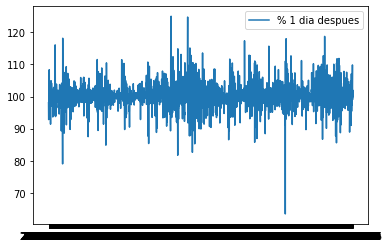

In [6]:
pl.plot(df_precio.iloc[:,0], df_precio.iloc[:,4], label = "% 1 dia despues")
pl.legend()
pl.show()

##### Los picos mas verticales indican las mayores explosiones de precio positivas y negativas (la mas pronunciada es la del dia que Elon Musk anuncio que dejaba de aceptar Bitcoin como metodo de pago en Tesla, y el mercado cayo un 50%). Son estos picos donde tenemos que centrar la atencion

#### Usar dataset de tweets prefabricado

In [10]:
df_tweets = df_tweets[df_tweets.is_retweet == False] # No tener en cuenta los retweets
df_tweets = df_tweets.drop(['user_location', 'user_created', 'user_description', 'user_friends', 'user_favourites', 'source', 'is_retweet'], axis=1)
df_tweets['date'] = df_tweets['date'].str[0:10] # Eliminar la hora, quedarnos solo con el dia
df_tweets

,user_name,user_followers,user_verified,date,text,hashtags
0,DeSota Wilson,8534.0,False,2021-02-10,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin']
1,CryptoND,6769.0,False,2021-02-10,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']"
2,Tdlmatias,128.0,False,2021-02-10,"Guys evening, I have read this article about B...",NaN
3,Crypto is the future,625.0,False,2021-02-10,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']"
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,1249.0,False,2021-02-10,This network is secured by 9 508 nodes as of t...,['BTC']
...,...,...,...,...,...,...
1751670,JomCRYPTO,5.0,False,2021-11-12,@WatcherGuru #Btc\n#ETH \n#LTC \n#COSMOS \n#St...,"['Btc', 'ETH', 'LTC', 'COSMOS', 'Stellar', 'Do..."
1751671,Ali,80.0,False,2021-11-12,@TheBitcoinConf @priceoftomorrow @addyinvest @...,"['shib', 'shiba', 'shiba_army', 'shibaw', 'shi..."
1751672,Muhammed,34.0,False,2021-11-12,@Heatherfernsby #pitbulltoken will be the doge...,"['pitbulltoken', 'pitbull', 'PitbullToken100x'..."
1751673,Francesco Santoro $VET,76.0,False,2021-11-12,I am changing the way I invest. In the wallet ...,"['VET', 'btc', 'BNB']"


In [ ]:
df_combA = pd.DataFrame()
df_combA = pd.merge(df_tweets, df_precio, left_on="date", right_on="Fecha")
df_combA = df_combA.drop(['date', 'hashtags', 'user_verified'], axis=1) # Con el merge se quedaban dos columnas de fecha -> eliminar una de ellas
df_combA

#### Guardar resultados en un fichero local para desahogar la memoria (en mi ordenador estaba saturada ya)

In [ ]:
df_combA.to_csv('df_combinadaA.csv')

In [3]:
df_combA = pd.read_csv("df_combinadaA.csv")
df_combA = df_combA.drop(['Unnamed: 0'], axis=1)
df_combA

,user_name,user_followers,text,Fecha,Precio,1d_atras,7d_atras,1d_despues,7d_despues
0,DeSota Wilson,8534.0,Blue Ridge Bank shares halted by NYSE after #b...,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961
1,CryptoND,6769.0,"😎 Today, that's this #Thursday, we will do a ""...",2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961
2,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,1249.0,This network is secured by 9 508 nodes as of t...,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961
3,Cryptocurrencies / EUR,4052.0,🔄 Prices update in $EUR (1 hour):\n\n$BTC - ...,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961
4,DeSota Wilson,8534.0,.@Tesla’s #bitcoin investment is revolutionary...,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961
...,...,...,...,...,...,...,...,...,...
359612,Bitcoin Beach,44734.0,@Adalber22496821 They watched how well it is w...,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152
359613,DYOR.net Dev & Bot,67468.0,[SCAN RESULTS - 15m]\n\nExchange: #KuCoin\n\nT...,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152
359614,Selene Crewshaw,1496.0,Sounds like warning to everyone out there who ...,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152
359615,Dan Emmons 💕+ ⏳=🤚💎✋,5157.0,Whoever rooted for #BTC to enter the Centraliz...,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152


#### Eliminar los tweets de quienes tienen un número de seguidores no representativo, ya que no tienen suficiente poder social como para variar significatvamente el precio de una empresa/criptomoneda

In [11]:
df_combA = df_combA.drop(df_combA[df_combA['user_followers'] < 1000].index)
df_combA.to_csv('df_combinadaA.csv')

#### Asignar a cada tweet el sentimiento. Llevado a Spyder, tiempo aproximado 3h30m

In [ ]:
from textblob import TextBlob
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

df_combA = pd.read_csv('internet_explorer/Ingenieria_informatica/Inteligencia_artificial/IA_precio_bitcoin_segun_tweets/df_combinadaA.csv')
tweets = df_combA['text']

polarity = 0
i=0
sentimientos = []

for tweet in tweets:
    analysis = TextBlob(tweet)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet)   
    polarity += analysis.sentiment.polarity
    sentimientos.append(score['compound'])    
    if(i%10000==0):
        print(i, "-", i/len(tweets)*100, "% ->", score)
    i+=1

df_combA['sentimiento'] = sentimientos
df_combA.to_csv('df_combinadaB.csv')

print(df_combA)

In [8]:
df_combB = pd.read_csv('df_combinadaB.csv')
df_combB = df_combB.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df_combB

,user_name,user_followers,text,Fecha,Precio,1d_atras,7d_atras,1d_despues,7d_despues,sentimiento
0,DeSota Wilson,8534.0,Blue Ridge Bank shares halted by NYSE after #b...,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.2960
1,CryptoND,6769.0,"😎 Today, that's this #Thursday, we will do a ""...",2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.4939
2,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,1249.0,This network is secured by 9 508 nodes as of t...,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.4019
3,Cryptocurrencies / EUR,4052.0,🔄 Prices update in $EUR (1 hour):\n\n$BTC - ...,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,-0.2023
4,DeSota Wilson,8534.0,.@Tesla’s #bitcoin investment is revolutionary...,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.0000
...,...,...,...,...,...,...,...,...,...,...
359612,Bitcoin Beach,44734.0,@Adalber22496821 They watched how well it is w...,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,0.7269
359613,DYOR.net Dev & Bot,67468.0,[SCAN RESULTS - 15m]\n\nExchange: #KuCoin\n\nT...,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,0.3818
359614,Selene Crewshaw,1496.0,Sounds like warning to everyone out there who ...,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,-0.2732
359615,Dan Emmons 💕+ ⏳=🤚💎✋,5157.0,Whoever rooted for #BTC to enter the Centraliz...,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,0.3400


In [11]:
# pd.order(df_sent['sentimiento'])
df2 = df_combB.sort_values(['sentimiento', 'user_followers'], ascending = (True, False))
print("\nO O O O O O O O O O O O O O O O O O O TWEETS MAS POSITIVOS O O O O O O O O O O O O O O O O O O O\n")
for i in range(3):    
    print(i+1, "----->", df2.iloc[len(df2)-1-i, 2])
    print("SUBIDA UN DIA DESPUES:", df2.iloc[len(df2)-1-i, 7])
    print("SUBIDA 7 DIAS DESPUES:", df2.iloc[len(df2)-1-i, 8])
print("\nO O O O O O O O O O O O O O O O O O O TWEETS MAS NEGATIVOS O O O O O O O O O O O O O O O O O O O\n")
for i in range(3):
    print(i+1, "----->", df2.iloc[i, 2])
    print("SUBIDA UN DIA DESPUES:", df2.iloc[i, 7])
    print("SUBIDA 7 DIAS DESPUES:", df2.iloc[i, 8])


O O O O O O O O O O O O O O O O O O O TWEETS MAS POSITIVOS O O O O O O O O O O O O O O O O O O O

1 -----> BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

BUYING OPPORTUNITY

#Bitcoin #BTC #HODL https://t.co/8ykkThv9In
SUBIDA UN DIA DESPUES: 92.56975190593498
SUBIDA 7 DIAS DESPUES: 82.4567978631432
2 -----> ⚠️⚠️⚠️⚠️warning ⚠️😳🤣😂😅 . .I do what I like
 I support who I like
...I don't know this man but I'm VERY IMPRESSED ...I have brought 2 things from him and I like the way he talks to everyone and I love his 🎨 win win win #dogecoin #bitcoin #etherium #herpes #safemoon #shibainu https://t.co/ELkj4gXlvL
SUBIDA UN DIA DESPUES: 98.50656920379988
SUBIDA 7 DIAS DESPUES: 103.1716480107089
3 -----> This is a great and excellent project and also the reward is great. Thanks for shared this wonderful opportu

#### Ha funcionado bastante mejor. Ahora que sabemos el sentimiento, podemos eliminar el contenido del tweet (para ahorrar memoria)

In [12]:
df_combB = df_combB.drop(['text'], axis=1)
df_combB

,user_name,user_followers,Fecha,Precio,1d_atras,7d_atras,1d_despues,7d_despues,sentimiento
0,DeSota Wilson,8534.0,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.2960
1,CryptoND,6769.0,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.4939
2,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,1249.0,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.4019
3,Cryptocurrencies / EUR,4052.0,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,-0.2023
4,DeSota Wilson,8534.0,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.0000
...,...,...,...,...,...,...,...,...,...
359612,Bitcoin Beach,44734.0,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,0.7269
359613,DYOR.net Dev & Bot,67468.0,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,0.3818
359614,Selene Crewshaw,1496.0,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,-0.2732
359615,Dan Emmons 💕+ ⏳=🤚💎✋,5157.0,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,0.3400


#### Guardar checkpoint

In [13]:
df_combB.to_csv('df_ligera1.csv')

In [3]:
df_lig1 = pd.read_csv('df_ligera1.csv')
df_lig1 = df_lig1.drop(['Unnamed: 0'], axis=1)
df_lig1

,user_name,user_followers,Fecha,Precio,1d_atras,7d_atras,1d_despues,7d_despues,sentimiento
0,DeSota Wilson,8534.0,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.2960
1,CryptoND,6769.0,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.4939
2,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,1249.0,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.4019
3,Cryptocurrencies / EUR,4052.0,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,-0.2023
4,DeSota Wilson,8534.0,2021-02-10,46469.761719,99.387194,76.417048,96.619198,105.890961,0.0000
...,...,...,...,...,...,...,...,...,...
359612,Bitcoin Beach,44734.0,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,0.7269
359613,DYOR.net Dev & Bot,67468.0,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,0.3818
359614,Selene Crewshaw,1496.0,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,-0.2732
359615,Dan Emmons 💕+ ⏳=🤚💎✋,5157.0,2021-09-10,46396.664063,98.659555,106.232314,96.709194,102.962152,0.3400


#### Añadir una columna con IDs de usuario, para poder trabajar con datos numericos (me lo llevo a spyder por temas de rendimiento). Funcionalidad no implementada finalmente

In [ ]:
import pandas as pd
df_lig1 = pd.read_csv('df_ligera1.csv')

df_lig2 = df_lig1
nombres = df_lig1['user_name']
unicos = df_lig1['user_name'].unique()
ids = [-1]*len(nombres)

for i in range(len(nombres)):
    j=-1
    while(nombres[i] != unicos[j]):
        j+=1
        if(j >= len(unicos)):
            break
    if(j == -1):
        j = len(unicos)
    ids[i] = j
    if(i%10000 == 0):
        print(i, "->", i/len(nombres)*100, "%")

df_lig1['id_user'] = ids

df_lig2.to_csv('df_ligera2.csv')

#### Guardar checkpoint

In [51]:
df_lig2 = pd.read_csv('df_ligera2.csv')
df_lig2 = df_lig2.drop(['Unnamed: 0', 'Unnamed: 0.1', 'user_name'], axis=1)
df_lig2['1d_atras'] = df_lig2['1d_atras']*df_lig2['Precio']/100
df_lig2['7d_atras'] = df_lig2['7d_atras']*df_lig2['Precio']/100
df_lig2['1d_despues'] = df_lig2['1d_despues']*df_lig2['Precio']/100
df_lig2['7d_despues'] = df_lig2['7d_despues']*df_lig2['Precio']/100
df_lig2

,user_followers,Fecha,Precio,1d_atras,7d_atras,1d_despues,7d_despues,sentimiento,id_user
0,8534.0,2021-02-10,46469.761719,46184.992188,35510.820313,44898.710938,49207.277344,0.2960,0
1,6769.0,2021-02-10,46469.761719,46184.992188,35510.820313,44898.710938,49207.277344,0.4939,1
2,1249.0,2021-02-10,46469.761719,46184.992188,35510.820313,44898.710938,49207.277344,0.4019,2
3,4052.0,2021-02-10,46469.761719,46184.992188,35510.820313,44898.710938,49207.277344,-0.2023,3
4,8534.0,2021-02-10,46469.761719,46184.992188,35510.820313,44898.710938,49207.277344,0.0000,0
...,...,...,...,...,...,...,...,...,...
359612,44734.0,2021-09-10,46396.664063,45774.742188,49288.250000,44869.839844,47771.003906,0.7269,572
359613,67468.0,2021-09-10,46396.664063,45774.742188,49288.250000,44869.839844,47771.003906,0.3818,18809
359614,1496.0,2021-09-10,46396.664063,45774.742188,49288.250000,44869.839844,47771.003906,-0.2732,30231
359615,5157.0,2021-09-10,46396.664063,45774.742188,49288.250000,44869.839844,47771.003906,0.3400,7594


#### Agrupar por dias, para conocer el sentimiento general de tweets en cada dia

In [52]:
df_lig2['sentim_global'] = df_lig2['user_followers']*df_lig2['sentimiento']
df_lig2 = df_lig2.drop(['user_followers', 'sentimiento', 'id_user'], axis=1)
df_lig2 = df_lig2.groupby(['Fecha'], as_index=False).mean()
df_lig2

,Fecha,Precio,1d_atras,7d_atras,1d_despues,7d_despues,sentim_global
0,2021-02-05,36931.546875,37475.105469,34318.671875,38138.386719,47877.035156,1382.502689
1,2021-02-06,38138.386719,36931.546875,34295.933594,39250.191406,47491.203125,735.322807
2,2021-02-07,39250.191406,38138.386719,34270.878906,38886.828125,47114.507813,-365.382499
3,2021-02-08,38886.828125,39250.191406,33114.578125,46184.992188,48696.535156,1741.744875
4,2021-02-09,46184.992188,38886.828125,33533.199219,46469.761719,47944.457031,1917.416587
...,...,...,...,...,...,...,...
73,2021-08-23,49291.675781,48869.105469,47019.960938,49562.347656,48834.851563,5695.549437
74,2021-08-24,49562.347656,49291.675781,45936.457031,47727.257813,47024.339844,6080.424441
75,2021-08-25,47727.257813,49562.347656,44686.750000,49002.640625,47099.773438,5610.088799
76,2021-08-26,49002.640625,47727.257813,44741.882813,46894.554688,48807.847656,4722.838601


#### Representación del precio contra el sentimiento diario

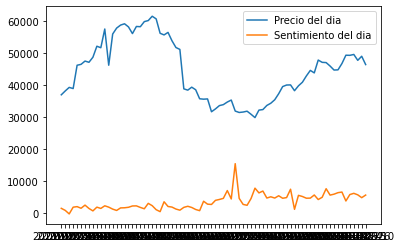

In [60]:
pl.plot(df_lig2.iloc[:,0], df_lig2.iloc[:,1], label = "Precio del dia")
pl.plot(df_lig2.iloc[:,0], df_lig2.iloc[:,6], label = "Sentimiento del dia")
pl.legend()
pl.show()

In [ ]:
df_lig2 = df_lig2.drop(['Fecha'], axis=1)
df_lig2.to_csv('df_ligera3.csv')
df_lig2

#### Cálculo de la predicción del día siguiente

In [207]:
df_lig3 = pd.read_csv('df_ligera3.csv')
df_lig3 = df_lig3.drop(['Unnamed: 0'], axis=1)
df_lig3

,Precio,1d_atras,7d_atras,1d_despues,7d_despues,sentim_global
0,36931.546875,37475.105469,34318.671875,38138.386719,47877.035156,1382.502689
1,38138.386719,36931.546875,34295.933594,39250.191406,47491.203125,735.322807
2,39250.191406,38138.386719,34270.878906,38886.828125,47114.507813,-365.382499
3,38886.828125,39250.191406,33114.578125,46184.992188,48696.535156,1741.744875
4,46184.992188,38886.828125,33533.199219,46469.761719,47944.457031,1917.416587
...,...,...,...,...,...,...
73,49291.675781,48869.105469,47019.960938,49562.347656,48834.851563,5695.549437
74,49562.347656,49291.675781,45936.457031,47727.257813,47024.339844,6080.424441
75,47727.257813,49562.347656,44686.750000,49002.640625,47099.773438,5610.088799
76,49002.640625,47727.257813,44741.882813,46894.554688,48807.847656,4722.838601


In [208]:
def calcDia():
    X = df_lig4[['Precio', '1d_atras', '7d_atras', 'sentim_global']]
    Y = np.array(df_lig4['1d_despues'])

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size =.25, random_state = 1)
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # clf = MLPRegressor(solver = 'lbfgs', alpha = 1e-5, hidden_layer_sizes = (5,))

    # model = clf.fit(X_train, y_train)

    # predictions = model.predict(X_test)
    # print("Grado de acierto:", r2_score(y_test, predictions))

    regr = MLPRegressor(solver='lbfgs', random_state=1, max_iter=10000).fit(X_train, y_train)
    verPrediccion = regr.predict(X_test[:1])
    # print(verPrediccion)
    return verPrediccion[0]

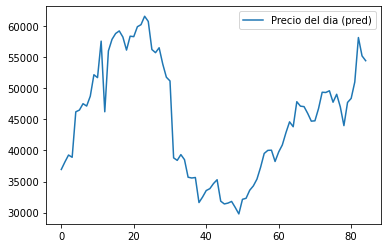

In [209]:
df_lig3 = pd.read_csv('df_ligera3.csv')
df_lig3 = df_lig3.drop(['Unnamed: 0'], axis=1)
df_lig3

df_lig4 = df_lig3
limiteInicial = len(df_lig3)-1

for i in range(8):
    precioDiario = calcDia()
    # print(i, "- Precio predecido para el dia:", precioDiario)
    df_lig4.loc[limiteInicial+i] = [precioDiario, df_lig4.iloc[limiteInicial+i-1,1], df_lig4.iloc[limiteInicial+i-7,2], 0, 0, 2000]
    # print(df_lig4.loc[limiteInicial+i])
    df_lig4.at[limiteInicial+i-1, '1d_despues'] = precioDiario
    df_lig4.at[limiteInicial+i-7, '7d_despues'] = precioDiario

contar = [0]*(len(df_lig4))
for i in range(len(df_lig4)):
    contar[i] = i

pl.plot(contar, df_lig4.iloc[:,0], label = "Precio del dia (pred)")
pl.legend()
pl.show()

df_lig3.to_csv("df_ligera4.csv")

#### Evolución real después de nuestra fecha límite (fente: Binance.com):
##### (Nuestro estudio abarca el contenido entre las dos lineas azules verticales)

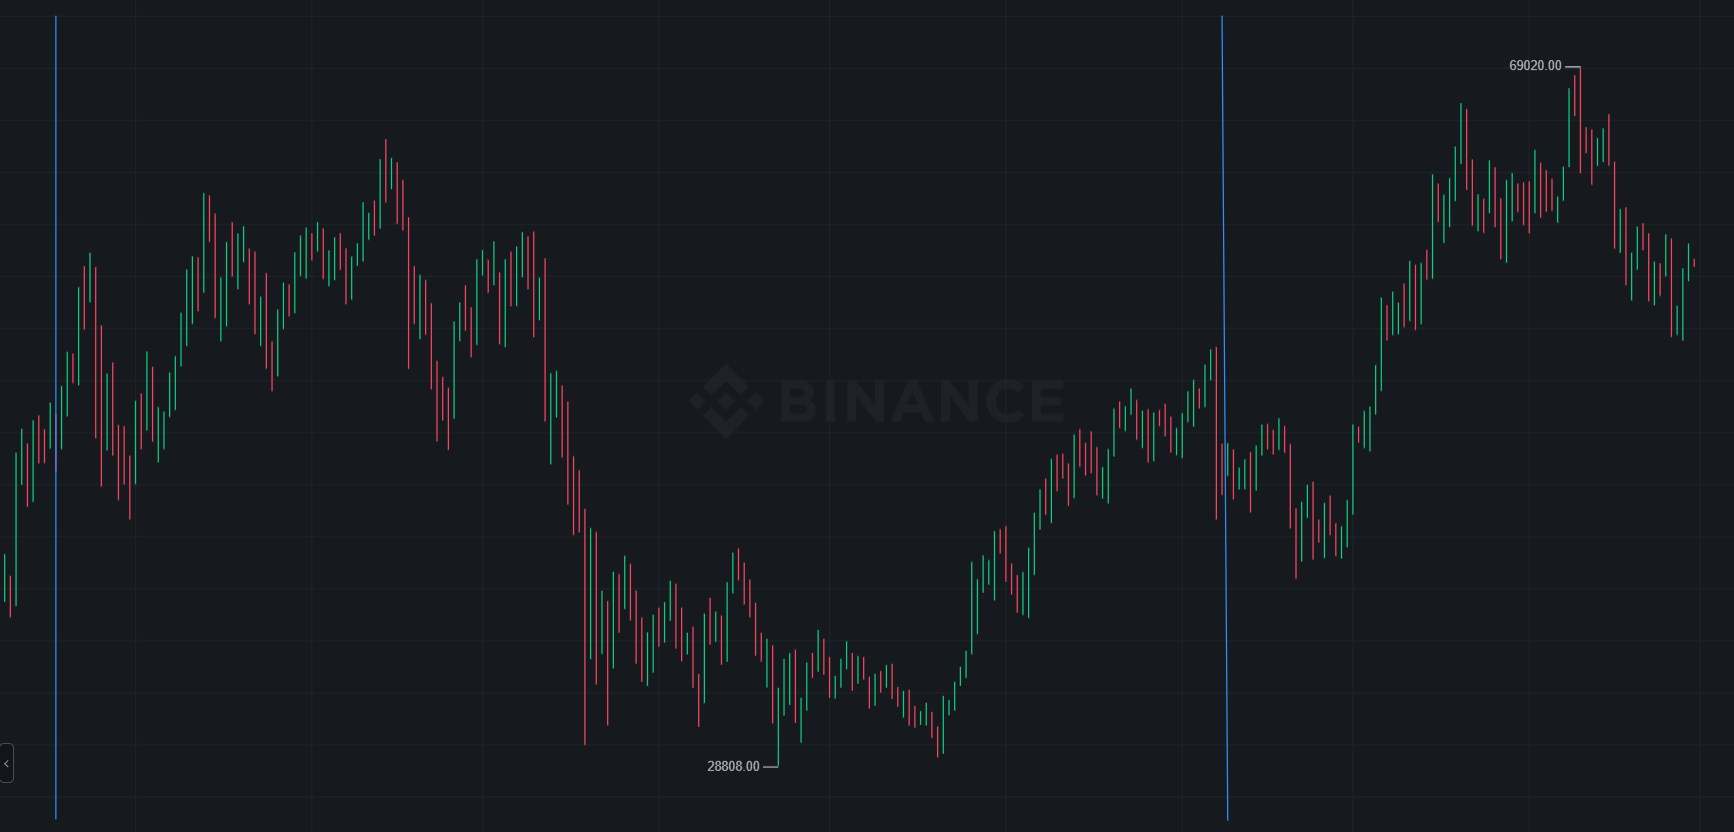

### Observamos que el modelo predice los precios con bastante precisión si fijamos un sentimiento del mercado de 2000, que en nuestra escala significaría un sentimiento ligeramente positivo respecto a Bitcoin, el cual, personalmente, considero que está bastante acorde al sentimiento de aquellas fechas.
### Por otro lado, vemos que el modelo responde bien a los primero 6-10 días, pero a partir de ahí empieza a responder de forma en exacta. Esto se debe a dos motivos: el primero porque en nuestro dataset solo le hemos hecho tener en cuenta los próximos 7 días (ya que se tratba d una herramienta de apoyo al trade), y segundo porque en intervalos de tiempo mayores siempre aparecen noticias externas a la criptomoneda que influyen significativamente en el precio (como nuevos brotes de COVID, empresas importantes que entran en bancarrota...)

In [1]:
# !pip install eli5
import pandas as pd
df_ant = pd.read_csv("df_ligera4.csv")
df_des = pd.read_csv("df_ligera4.csv")
df_ant = df_ant.drop(['Unnamed: 0'], axis=1)
import eli5
import matplotlib.pyplot as plt
import matplotlib.pyplot as pl
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
df_ant.head(1)

,Precio,1d_atras,7d_atras,1d_despues,7d_despues,sentim_global
0,36931.546875,37475.105469,34318.671875,38138.386719,47877.035156,1382.502689


In [2]:
precio_5d_atras = list()
precio_20d_atras  = list()
precio_50d_atras  = list()
precio_2d_despues = list()
precio_3d_despues = list()

for i in range(len(df_ant)):
    if(i>4):   
        precio_5d_atras.append(df_ant.iloc[i-5,1])
    else:
        precio_5d_atras.append(df_ant.iloc[i,1]) # Si no hay suficientes dias antes, asignarle el precio del dia actual, para que no se quede vacio y de problemas
      
    if(i>19):
        precio_20d_atras.append(df_ant.iloc[i-20,1])
    else:
        precio_20d_atras.append(df_ant.iloc[i,1]) # Si no hay suficientes dias antes, asignarle el precio del dia actual, para que no se quede vacio y de problemas
    
    if(i>49):
        precio_50d_atras.append(df_ant.iloc[i-50,1])
    else:
        precio_50d_atras.append(df_ant.iloc[i,1])
        
    if(i<len(df_ant)-2):
        precio_2d_despues.append(df_ant.iloc[i+2,1])
    else:
        precio_2d_despues.append(df_ant.iloc[i,1])
        
    if(i<len(df_ant)-3):
        precio_3d_despues.append(df_ant.iloc[i+3,1])
    else:
        precio_3d_despues.append(df_ant.iloc[i,1])
    
df_ant.loc[:, '5d_atras'] = precio_5d_atras
df_ant.loc[:, '20d_atras'] = precio_20d_atras
df_ant.loc[:, '50d_atras'] = precio_50d_atras
df_ant.loc[:, '2d_despues'] = precio_3d_despues
df_ant.loc[:, '3d_despues'] = precio_3d_despues

In [29]:
X = df_ant[["Precio", "1d_atras", "5d_atras", "7d_atras", "20d_atras", "50d_atras"]]
y = df_ant["sentim_global"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train, eval_metric = 'logloss')
eli5.show_weights(xgb.get_booster())
# df_booster = eli5.explain_weights_df(xgb.get_booster())
# df_booster.sort_values(by=['feature'])

Weight,Feature
0.4256,1d_atras
0.1383,5d_atras
0.1213,7d_atras
0.1204,Precio
0.1047,50d_atras
0.0896,20d_atras


In [4]:
df_pesos = pd.DataFrame()
df_pesos["Columna"] = [1, 5, 7, 20, 50]
df_pesos["Peso"] = [0.4256, 0.1383, 0.1213, 0.0896, 0.1047]

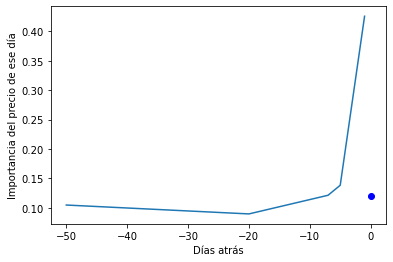

In [9]:
pl.plot(-df_pesos["Columna"], df_pesos["Peso"], label = "Importancia del precio anterior en el sentimiento")
plt.plot(0, 0.1204, 'bo', 0.1) 
pl.xlabel('Días atrás')
pl.ylabel('Importancia del precio de ese día')
pl.show()